In [97]:
from tes.data import Data,PacketStream,Packet,Payload,EventFlags
from tes.hdf5 import _PacketData, _import
import numpy as np
import matplotlib.pyplot as plt
from subprocess import Popen

import logging
import sys
logger = logging.getLogger('tes')
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s:%(levelname)s %(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

trace_dt=np.dtype([('f','i4'),('s','i4')])
min_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),('low','i4'),('high','i4'),
    ('flags', (np.int32, {'f0':(np.uint8,0),'f1':(np.uint8,1),'f2':(np.uint8,2), 'f3':(np.uint8,3)})),
    ('max_slope','i4')
])
max_dt=np.dtype([
    ('clk','i4'),('f','i4'),('s','i4'),
    ('flags', (np.int32, {'f0':(np.uint8,0),'f1':(np.uint8,1),'f2':(np.uint8,2), 'f3':(np.uint8,3)}))
])

xing_dt=np.dtype('i4')

def xings(s, thresh):
    xing = np.zeros_like(s)
    i=0
    was_above = s[0] > thresh
    for i in range(1, len(s)):
        if s[i] > thresh:
            if not was_above:
                xing[i] = 1
            was_above = True
        if s[i] < thresh:
            if was_above:
                xing[i] = -1
            was_above = False
            
    return np.where(xing==1)[0], np.where(xing==-1)[0]


In [186]:
traces=Data.fromfile('traces',trace_dt,'teslib','CFD_TB',tool='vivado')
min_data=Data.fromfile('min_data',min_dt,'teslib','CFD_TB',tool='vivado')
max_data=Data.fromfile('max_data',max_dt,'teslib','CFD_TB',tool='vivado')
# low_xing=Data.fromfile('low_xings',xing_dt,'teslib','CFD_TB',tool='vivado')
# high_xing=Data.fromfile('high_xings',xing_dt,'teslib','CFD_TB',tool='vivado')
# maxslope_xing=Data.fromfile('maxslope_xings',xing_dt,'teslib','CFD_TB',tool='vivado')
f=traces['f']
s=traces['s']
mins, maxs = xings(s,0)

In [187]:
pthresh=0
sthresh=0
cf=(pow(2,17)//5)
if maxs[0] < mins[0]:
    maxs = maxs[1:] #start with a min
for i in range(len(min_data)):
    min_i = min_data['clk'][i]
    max_i = max_data['clk'][i]
    min_f0=np.unpackbits(min_data['flags']['f0'][i])
    min_f1=np.unpackbits(min_data['flags']['f1'][i])
    max_f0=np.unpackbits(max_data['flags']['f0'][i])
    max_f1=np.unpackbits(max_data['flags']['f1'][i])
    
    if mins[i] != min_i:
        print('min:index mismatch i:{} min_data={} mins={}'.format(i,min_i,mins[i]))
        break
    if maxs[i] != max_i:
        print('max:index mismatch i:{} min_data={} mins={}'.format(i,max_i,maxs[i]))
        break
    
    maxima = f[maxs[i]]
    minima = f[mins[i]]
    will_cross = maxima > pthresh
    will_arm = len(np.where(s[mins[i]:maxs[i]+1]>sthresh))!=0
    valid_rise = will_arm and will_cross
    first_rise = minima <= pthresh
    pulse_start = valid_rise and first_rise
    
    if will_cross != min_f0[3]==1:
        print(
            'will_cross mismatch @min: i={} min_data={} will_cross={}'.format(i,min_f0[3]==1,will_cross)
        )
    if will_cross != max_f0[3]==1:
        print(
            'will_cross mismatch @max: i={} max_data={} will_cross={}'.format(i,max_f0[3]==1,will_cross)
        )
    if will_arm != min_f0[4]==1:
        print(
            'will_arm mismatch @min: i={} min_data={} will_arm={}'.format(i,min_f0[4]==1,will_arm)
        )
    if will_arm != max_f0[4]==1:
        print(
            'will_arm mismatch @max: i={} max_data={} will_arm={}'.format(i,max_f0[4]==1,will_arm)
        )
    
    if valid_rise != min_f1[0]==1:
        print(
            'valid_rise mismatch @min: i={} min_data={} valid_rise={}'
            .format(i,min_f1[1]==1,valid_rise)
        )
    if valid_rise != max_f1[0]==1:
        print(
            'valid_rise mismatch @max: i={} max_data={} (will_arm and will_cross)={}'
            .format(i,max_f1[0]==1,valid_rise)
        )
        
    #rise_start
    if valid_rise != min_f0[1]==1:
        print(
            'rise_start mismatch @min: i={} min_data={} rise_start={}'
            .format(i,min_f0[1]==1,valid_rise)
        )
        
    if pulse_start != min_f0[2]==1:
        print(
            'pulse_start mismatch @min: i={} min_data={} rise_start={}'
            .format(i,min_f0[2]==1,pulse_start)
        )
        
    
    if min_data['f'][i] != minima:
        print('minima mismatch i={} min_data={} mins={}'.format(i,min_data['f'],f[mins[i]]))
    if max_data['f'][i] != maxima:
        print('maxima mismatch i={} max_data={} maxs={}'.format(i,max_data['f'],f[maxs[i]]))
    
    if first_rise: 
        if min_f0[0] == 0:
            print('missing first rise @min:i={} clk={}'.format(i,min_i))
        if max_f0[0] == 0:
            print('missing first rise @max:i={} clk={}'.format(i,max_i))
        cfi = f[maxs[i]]*cf
        cf_min = 0
    else: 
        if min_f0[0] == 1:
            print('unexpected first rise @min:i={}'.format(i))
        if max_f0[0] == 1:
            print('unexpected first rise @max:i={}'.format(i))
        cfi = (maxima-minima)*cf
        cf_min = minima
        
    cfi_f,_ = np.modf(cfi)
    cfi_i = np.right_shift(cfi,17)
#     if np.abs(cfi_f) >= 0.5:
#         cfi_i= int(cfi_i)+np.sign(cfi)
    high = maxima-cfi_i
    low= cf_min+cfi_i
    
#         p=(f[maxs[i]]-f[mins[i]]
    if min_data['high'][i] != high:
        print('high mismatch i={} min_data={} high={}'.format(i,min_data['high'][i],high))
    if min_data['low'][i] != low:
        print('high mismatch i={} min_data={} high={}'.format(i,min_data['low'][i],low))
    
    cfd_error = low < minima
    
    
#     if isempty(low_above):
#     check_xings(low,low_xing,'low_p')
        
    
    if cfd_error:
        if min_f0[5] == 0:
            print('missing cfd_error @min minima={} low={} i={} clk={}'.format(minima,low,i,min_i))
        if min_f0[7] == 1:
            print('unexpected cfd_valid @min minima={} low={} i={} clk={}'.format(minima,low,i,min_i))
        if max_f0[7] == 1:
            print('unexpected cfd_valid @max minima={} low={} i={} clk={}'.format(minima,low,i,max_i))
    else:
        if min_f0[5] == 1:
            print('unexpected cfd_error @min minima={} low={} i={} clk={}'.format(minima,low,i,min_i))
        if min_f0[7] == 0:
            print('missing cfd_valid @min minima={} low={} i={} clk={}'.format(minima,low,i,min_i))
        if max_f0[7] == 0:
            print('missing cfd_valid @max minima={} low={} i={} clk={}'.format(minima,low,i,max_i))
        
    m_slope = max(s[mins[i]:maxs[i]])
    if m_slope != min_data['max_slope'][i]:
        print(
            'max_slope mismatch i={} min_data={} max slope={}'.format(i,min_data['max_slope'][i],m_slope)
        )

#     check_xings(m_slope,s,maxslope_xing,'max_slope_p')
    
# check xings how to find 
    
            
print(len(min_data))

max_slope_p crossing mismatch i=1 data=1344 max_slope_p=1385
max_slope_p crossing mismatch i=2 data=1506 max_slope_p=1511
missing max_slope_p crossing clk=1582
missing max_slope_p crossing clk=1663
max_slope_p crossing mismatch i=5 data=1748 max_slope_p=1757
missing max_slope_p crossing clk=1902
max_slope_p crossing mismatch i=7 data=2053 max_slope_p=2062
max_slope_p crossing mismatch i=8 data=2168 max_slope_p=2182
missing max_slope_p crossing clk=2275
max_slope_p crossing mismatch i=10 data=2418 max_slope_p=2423
max_slope_p crossing mismatch i=11 data=2618 max_slope_p=2628
missing max_slope_p crossing clk=2869
max_slope_p crossing mismatch i=13 data=3043 max_slope_p=3055
max_slope_p crossing mismatch i=14 data=3125 max_slope_p=3134
missing max_slope_p crossing clk=3236
missing max_slope_p crossing clk=3403
max_slope_p crossing mismatch i=17 data=3480 max_slope_p=3496
multiple max_slope_p crossings i=18
multiple max_slope_p crossings i=19
multiple max_slope_p crossings i=20
missing max

max_slope_p crossing mismatch i=389 data=52455 max_slope_p=52539
missing max_slope_p crossing clk=52611
missing max_slope_p crossing clk=52691
max_slope_p crossing mismatch i=392 data=52762 max_slope_p=52782
missing max_slope_p crossing clk=52853
missing max_slope_p crossing clk=52942
max_slope_p crossing mismatch i=395 data=53087 max_slope_p=53103
max_slope_p crossing mismatch i=396 data=53176 max_slope_p=53195
missing max_slope_p crossing clk=53278
missing max_slope_p crossing clk=53466
max_slope_p crossing mismatch i=399 data=53545 max_slope_p=53591
missing max_slope_p crossing clk=53670
missing max_slope_p crossing clk=53759
missing max_slope_p crossing clk=53851
max_slope_p crossing mismatch i=403 data=53997 max_slope_p=54012
missing max_slope_p crossing clk=54157
missing max_slope_p crossing clk=54286
missing max_slope_p crossing clk=54391
missing max_slope_p crossing clk=54501
max_slope_p crossing mismatch i=408 data=54628 max_slope_p=54655
missing max_slope_p crossing clk=54790

max_slope_p crossing mismatch i=1837 data=243801 max_slope_p=243831
missing max_slope_p crossing clk=243917
max_slope_p crossing mismatch i=1839 data=244035 max_slope_p=244096
missing max_slope_p crossing clk=244211
max_slope_p crossing mismatch i=1841 data=244297 max_slope_p=244304
max_slope_p crossing mismatch i=1842 data=244432 max_slope_p=244440
max_slope_p crossing mismatch i=1843 data=244569 max_slope_p=244579
missing max_slope_p crossing clk=244716
max_slope_p crossing mismatch i=1845 data=244791 max_slope_p=244816
max_slope_p crossing mismatch i=1847 data=244993 max_slope_p=245025
missing max_slope_p crossing clk=245132
missing max_slope_p crossing clk=245202
missing max_slope_p crossing clk=245292
max_slope_p crossing mismatch i=1851 data=245371 max_slope_p=245382
max_slope_p crossing mismatch i=1852 data=245493 max_slope_p=245507
missing max_slope_p crossing clk=245610
max_slope_p crossing mismatch i=1854 data=245676 max_slope_p=245698
max_slope_p crossing mismatch i=1855 dat

missing max_slope_p crossing clk=476705
max_slope_p crossing mismatch i=3631 data=476783 max_slope_p=476802
max_slope_p crossing mismatch i=3632 data=476865 max_slope_p=476881
missing max_slope_p crossing clk=477025
max_slope_p crossing mismatch i=3634 data=477131 max_slope_p=477139
missing max_slope_p crossing clk=477227
max_slope_p crossing mismatch i=3636 data=477296 max_slope_p=477317
missing max_slope_p crossing clk=477477
max_slope_p crossing mismatch i=3638 data=477603 max_slope_p=477626
missing max_slope_p crossing clk=477744
missing max_slope_p crossing clk=477868
max_slope_p crossing mismatch i=3641 data=477956 max_slope_p=477976
missing max_slope_p crossing clk=478087
max_slope_p crossing mismatch i=3643 data=478187 max_slope_p=478221
missing max_slope_p crossing clk=478294
missing max_slope_p crossing clk=478429
max_slope_p crossing mismatch i=3646 data=478550 max_slope_p=478592
missing max_slope_p crossing clk=478732
missing max_slope_p crossing clk=478818
max_slope_p cros

In [185]:
def check_xings(thresh,seq,data,lable):
    above = np.where(seq[mins[i]:maxs[i]+1]>=thresh)[0]+mins[i]
    data_xings = data[np.logical_and(data >= mins[i], data <= maxs[i])]
    if not len(above):
        if len(data_xings):
            print('unxpected {} crossing clk={}'.format(lable,data_xings[0]))
    elif not len(data_xings):
            print('missing {} crossing clk={}'.format(lable,above[0]))
    else:
        if len(data_xings) > 1:
            print('multiple {} crossings i={}'.format(lable,i))
        else:
            if data_xings[0] != above[0]:
                print(
                    '{} crossing mismatch i={} data={} {}={}'
                    .format(lable,i,data_xings[0],lable,above[0])
                )
        

In [15]:
j=0
min_data['low'][j]<f[mins[j]]

False

In [188]:
j=1
maxslope_xing[np.logical_and(maxslope_xing >= mins[j], maxslope_xing <= maxs[j])]

array([1344])

In [189]:
np.where(s[mins[j]:maxs[j]+1]>=min_data['max_slope'][j])[0]

array([62, 63, 64], dtype=int64)

In [191]:
mins[j],maxs[j],min_data['max_slope'][j]

(1323, 1428, 152)

In [179]:
np.where(s[mins[j]:maxs[j]]>=min_data['max_slope'][j])[0]+mins[j]

array([1385, 1386, 1387], dtype=int64)

In [164]:
maxslope_xing

array([  1172,   1344,   1506, ..., 370071, 370319, 370425])

In [166]:
s[1172],m_slope

(1, 87)

In [190]:
max(s[mins[j]:maxs[j]]),min_data['max_slope'][j]

(152, 152)

<IPython.core.display.Javascript object>


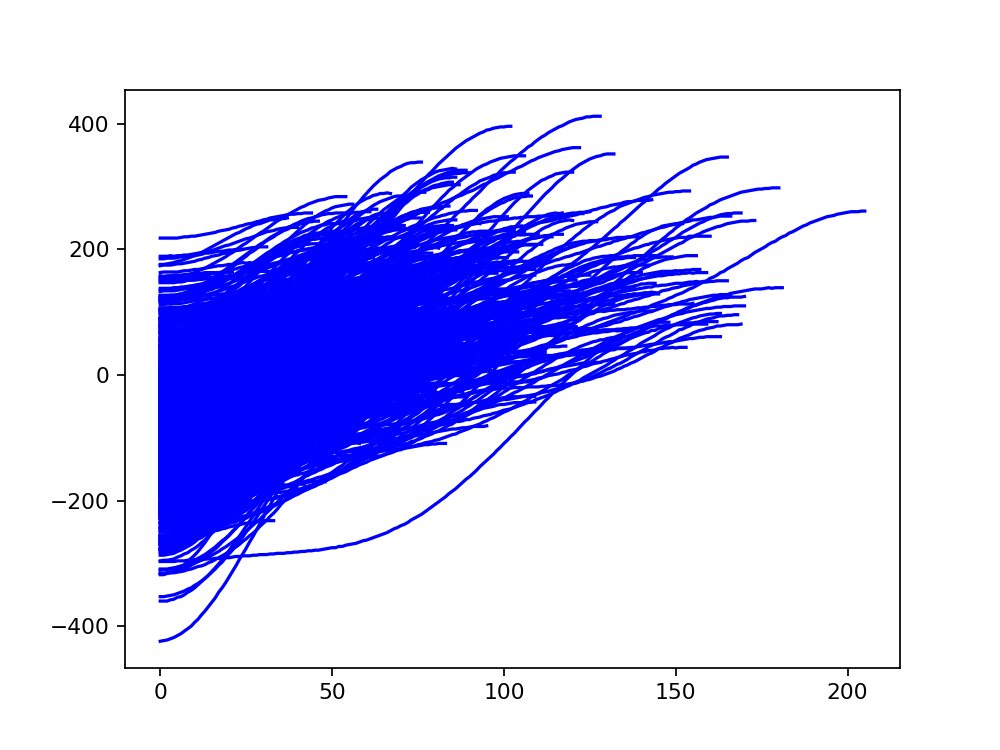

In [183]:
%matplotlib notebook
for k in range(1, 1000):
#     plt.plot([0,l],[0,0],':k')
#     plt.plot(s[mins[k]:maxs[k]+1],'r')
    plt.plot(f[mins[k]:maxs[k]+1],'b')